In [59]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "Web STORM"
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

In [60]:
from langchain_openai import ChatOpenAI

fast_llm = ChatOpenAI(model="gpt-4o-mini")
# Uncomment for a Fireworks model
# fast_llm = ChatFireworks(model="accounts/fireworks/models/firefunction-v1", max_tokens=32_000)
long_context_llm = ChatOpenAI(model="gpt-4o")

#### Generate Initial Outline

In [61]:
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate

from pydantic import BaseModel, Field

direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a Wikipedia writer. Write an outline for a Wikipedia page about a user-provided topic. Be comprehensive and specific.",
        ),
        ("user", "{topic}"),
    ]
)

class Subsection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    description: str = Field(..., title="Content of the subsection")
    
    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.description}".strip()
    
class Section(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    description: str = Field(..., title="Content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )

    
    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            f"### {subsection.subsection_title}\n\n{subsection.description}"
            for subsection in self.subsections or []
        )
        return f"## {self.section_title}\n\n{self.description}\n\n{subsections}".strip()
    
class Outline(BaseModel):
    page_title: str = Field(..., title="Title of the Wikipedia page")
    sections: List[Section] = Field(
        default_factory=list,
        title="Titles and descriptions for each section of the Wikipedia page.",
    )

    @property
    def as_str(self) -> str:
        sections = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections}".strip()


generate_outline_direct = direct_gen_outline_prompt | fast_llm.with_structured_output(
    Outline
)

In [62]:
example_topic = "Impact of million-plus token context window language models on RAG"

initial_outline = generate_outline_direct.invoke({"topic": example_topic})

print(initial_outline.as_str)

# Impact of Million-Plus Token Context Window Language Models on RAG

## Introduction

An overview of language models with million-plus token context windows and their relevance to retrieval-augmented generation (RAG) systems.

## Background

A discussion of traditional language models and their limitations regarding context windows. Introduction to RAG and its significance in natural language processing.

## Million-Plus Token Context Window Language Models

Exploration of the development and capabilities of language models that can process over a million tokens.

## Retrieval-Augmented Generation (RAG)

An overview of the RAG framework, its components, and how it integrates retrieval mechanisms with generation capabilities.

## Impact on RAG Systems

Analysis of how million-plus token context window language models influence RAG systems.

## Advantages

Detailed examination of the benefits that million-plus token context windows bring to RAG, including improved coherence, context ret

#### Generate Related Topics

In [63]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    """I'm writing a Wikipedia page for a topic mentioned below. Please identify and recommend some Wikipedia pages on closely related subjects. I'm looking for examples that provide insights into interesting aspects commonly associated with this topic, or examples that help me understand the typical content and structure included in Wikipedia pages for similar topics.

Please list only 3 subjects.

Topic of interest: {topic}
"""
)


class RelatedSubjects(BaseModel):
    topics: List[str] = Field(
        description="Comprehensive list of related subjects as background research.",
    )


expand_chain = gen_related_topics_prompt | fast_llm.with_structured_output(
    RelatedSubjects
)

In [58]:
related_subjects = await expand_chain.ainvoke({"topic": example_topic})
related_subjects

RelatedSubjects(topics=['million-plus token context window language models', 'retrieval-augmented generation (RAG)', 'natural language processing (NLP)'])

#### Generate Perspectives

In [97]:
class Editor(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the editor.",
    )
    name: str = Field(
        description="Name of the editor. Don't use any special characters or spaces.", pattern=r"^[a-zA-Z0-9_-]{1,64}$"
    )
    role: str = Field(
        description="Role of the editor in the context of the topic.",
    )
    description: str = Field(
        description="Description of the editor's focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


class Perspectives(BaseModel):
    editors: List[Editor] = Field(
        description="Comprehensive list of editors with their roles and affiliations.",
        # Add a pydantic validation/restriction to be at most M editors
    )


gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You need to select a diverse (and distinct) group of Wikipedia editors who will work together to create a comprehensive article on the topic. Each of them represents a different perspective, role, or affiliation related to this topic.\
    You can use other Wikipedia pages of related topics for inspiration. For each editor, add a description of what they will focus on. Generate only 3 editors.

    Wiki page outlines of related topics for inspiration:
    {examples}""",
        ),
        ("user", "Topic of interest: {topic}"),
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | ChatOpenAI(
    model="gpt-4o-mini"
).with_structured_output(Perspectives)

In [98]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables import chain as as_runnable

wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)


def format_doc(doc, max_length=1000):
    related = "- ".join(doc.metadata["categories"])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[
        :max_length
    ]


def format_docs(docs):
    return "\n\n".join(format_doc(doc) for doc in docs)


@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({"topic": topic})
    retrieved_docs = await wikipedia_retriever.abatch(
        related_subjects.topics, return_exceptions=True
    )
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({"examples": formatted, "topic": topic})

In [ ]:
perspectives = await survey_subjects.ainvoke(example_topic)

In [83]:
perspectives.dict()

{'editors': [{'affiliation': 'University of Technology, AI Research Lab',
   'name': 'drAliceSmith',
   'role': 'AI Researcher',
   'description': 'Dr. Smith will focus on the theoretical advancements in large language models (LLMs) with million-plus token context windows, examining their architecture, training methodologies, and implications for retrieval-augmented generation (RAG). She is particularly interested in how these models enhance the relevance and accuracy of generated responses.'},
  {'affiliation': 'Tech Company, NLP Engineering Team',
   'name': 'johnDoe',
   'role': 'NLP Engineer',
   'description': 'John will analyze practical applications of million-token context window models within RAG systems in industry settings. His insights will include case studies where these models have improved performance in enterprise-level chatbots and document retrieval systems, discussing challenges faced during implementation.'},
  {'affiliation': 'University of Linguistics and Cogniti

#### State

In [99]:
from typing import Annotated 

from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START

def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right

def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references

def update_editor(editor, new_editor):
    if not editor:
        return new_editor
    return editor

class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

In [100]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langchain_core.prompts import MessagesPlaceholder

gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an experienced Wikipedia writer and want to edit a specific page. \
Besides your identity as a Wikipedia writer, you have a specific focus when researching the topic. \
Now, you are chatting with an expert to get information. Ask good questions to get more useful information.

When you have no more questions to ask, say "Thank you so much for your help!" to end the conversation.\
Please only ask one question at a time and don't ask what you have asked before.\
Your questions should be related to the topic you want to write.
Be comprehensive and curious, gaining as much unique insight from the expert as possible.\

Stay true to your specific perspective:

{persona}""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

def tag_with_name(ai_messages: AIMessage, name: str):
    ai_messages.name = name
    return ai_messages

def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state["messages"]:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={"type"}))
        converted.append(message)
    return {"messages": converted}

@as_runnable
async def generate_question(state: InterviewState):
    editor = state["editor"]
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | fast_llm 
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {"messages": [result]}

In [103]:
messages = [
    HumanMessage(f"So you said you were writing an article on {example_topic}?")
]
question = await generate_question.ainvoke(
    {
        "editor": perspectives.editors[0],
        "messages": messages,
    }
)

question["messages"][0].content

"Yes, I'm focusing on how large language models (LLMs) with million-plus token context windows influence retrieval-augmented generation (RAG) methodologies. What specific aspects of these models and their impact on RAG would you say are the most significant or noteworthy?"

#### Answer Question

In [104]:
class Queries(BaseModel):
    queries: List[str] = Field(
        description="Comprehensive list of search engine queries to answer the user's questions.",
    )

gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful research assistant. Query the search engine to answer the user's questions.",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)
gen_queries_chain = gen_queries_prompt | ChatOpenAI(
    model="gpt-4o-mini"
).with_structured_output(Queries, include_raw=True)

In [105]:
queries = await gen_queries_chain.ainvoke(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
queries["parsed"].queries

['impact of large language models on retrieval-augmented generation',
 'million-plus token context windows in LLMs',
 'how do LLMs influence RAG methodologies',
 'significant aspects of LLMs for retrieval-augmented generation',
 'benefits of large context windows in LLMs for RAG',
 'challenges of using large language models in RAG',
 'Case studies of RAG with large context window LLMs']

In [106]:
class AnswerWithCitations(BaseModel):
    answer: str = Field(
        description="Comprehensive answer to the user's question with citations.",
    )
    cited_urls: List[str] = Field(
        description="List of urls cited in the answer.",
    )

    @property
    def as_str(self) -> str:
        return f"{self.answer}\n\nCitations:\n\n" + "\n".join(
            f"[{i+1}]: {url}" for i, url in enumerate(self.cited_urls)
        )


gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert who can use information effectively. You are chatting with a Wikipedia writer who wants\
 to write a Wikipedia page on the topic you know. You have gathered the related information and will now use the information to form a response.

Make your response as informative as possible and make sure every sentence is supported by the gathered information.
Each response must be backed up by a citation from a reliable source, formatted as a footnote, reproducing the URLS after your response.""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

gen_answer_chain = gen_answer_prompt | fast_llm.with_structured_output(
    AnswerWithCitations, include_raw=True
).with_config(run_name="GenerateAnswer")

In [107]:
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_core.tools import tool

'''
# Tavily is typically a better search engine, but your free queries are limited
search_engine = TavilySearchResults(max_results=4)

@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    results = tavily_search.invoke(query)
    return [{"content": r["content"], "url": r["url"]} for r in results]
'''

# DDG
search_engine = DuckDuckGoSearchAPIWrapper()


@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query)
    return [{"content": r["body"], "url": r["href"]} for r in results]

In [108]:
import json

from langchain_core.runnables import RunnableConfig


async def gen_answer(
    state: InterviewState,
    config: Optional[RunnableConfig] = None,
    name: str = "Subject_Matter_Expert",
    max_str_len: int = 15000,
):
    swapped_state = swap_roles(state, name)  # Convert all other AI messages
    queries = await gen_queries_chain.ainvoke(swapped_state)
    query_results = await search_engine.abatch(
        queries["parsed"].queries, config, return_exceptions=True
    )
    successful_results = [
        res for res in query_results if not isinstance(res, Exception)
    ]
    all_query_results = {
        res["url"]: res["content"] for results in successful_results for res in results
    }
    # We could be more precise about handling max token length if we wanted to here
    dumped = json.dumps(all_query_results)[:max_str_len]
    ai_message: AIMessage = queries["raw"]
    tool_call = queries["raw"].tool_calls[0]
    tool_id = tool_call["id"]
    tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
    swapped_state["messages"].extend([ai_message, tool_message])
    # Only update the shared state with the final answer to avoid
    # polluting the dialogue history with intermediate messages
    generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated["parsed"].cited_urls)
    # Save the retrieved information to a the shared state for future reference
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated["parsed"].as_str)
    return {"messages": [formatted_message], "references": cited_references}

In [93]:
example_answer = await gen_answer(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
example_answer["messages"][-1].content

"The introduction of large language models (LLMs) with million-plus token context windows significantly enhances the architecture and functionality of retrieval-augmented generation (RAG) systems. Firstly, the extended context windows allow LLMs to process and integrate a larger volume of information simultaneously, which is crucial for understanding complex queries and generating more coherent and contextually relevant responses. This capability enables the models to consider a broader scope of information, making it possible to generate responses that are more informed and grounded in reality, as they can reference a larger amount of relevant data from the retrieval system directly within the context window itself[^1^][^2^].\n\nMoreover, the architecture of LLMs with large context windows typically involves modifications to how information is encoded and represented. For instance, positional interpolation techniques may be employed to extend the context effectively, allowing the mode

#### Interview Graph

In [109]:
max_num_turns = 5
from langgraph.pregel import RetryPolicy


def route_messages(state: InterviewState, name: str = "Subject_Matter_Expert"):
    messages = state["messages"]
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]
    if last_question.content.endswith("Thank you so much for your help!"):
        return END
    return "ask_question"


builder = StateGraph(InterviewState)

builder.add_node("ask_question", generate_question, retry=RetryPolicy(max_attempts=3))
builder.add_node("answer_question", gen_answer, retry=RetryPolicy(max_attempts=3))
builder.add_conditional_edges("answer_question", route_messages)
builder.add_edge("ask_question", "answer_question")

builder.add_edge(START, "ask_question")
interview_graph = builder.compile().with_config(
    run_name="Conduct Interviews"
)

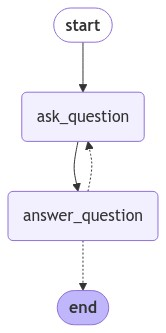

In [110]:
from IPython.display import Image, display

try:
    display(Image(interview_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [111]:
final_step = None

initial_state = {
    "editor": perspectives.editors[0],
    "messages": [
        AIMessage(
            content=f"So you said you were writing an article on {example_topic}?",
            name="Subject_Matter_Expert",
        )
    ],
}
async for step in interview_graph.astream(initial_state):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name]["messages"])[:300])
final_step = step

ask_question
--  [AIMessage(content="Yes, that's correct! I'm particularly interested in understanding how large language models (LLMs) with million-plus token context windows influence retrieval-augmented generation (RAG) processes. Could you explain how these extended context windows improve the relevance and accu
answer_question
--  [AIMessage(content='Large language models (LLMs) with million-plus token context windows significantly enhance retrieval-augmented generation (RAG) processes by allowing these models to process and utilize vast amounts of information at once. The primary advantage of extended context windows is the 
ask_question
--  [AIMessage(content="That's an excellent overview! Given that the integration of extensive context windows leads to improved performance in RAG, could you elaborate on the specific architectural changes or training methodologies used to develop these million-plus token context LLMs? How do these chan
answer_question
--  [AIMessage(content="The

In [112]:
final_state = next(iter(final_step.values()))

#### Refine Outline

In [113]:
refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a Wikipedia writer. You have gathered information from experts and search engines. Now, you are refining the outline of the Wikipedia page. \
You need to make sure that the outline is comprehensive and specific. \
Topic you are writing about: {topic} 

Old outline:

{old_outline}""",
        ),
        (
            "user",
            "Refine the outline based on your conversations with subject-matter experts:\n\nConversations:\n\n{conversations}\n\nWrite the refined Wikipedia outline:",
        ),
    ]
)

# Using turbo preview since the context can get quite long
refine_outline_chain = refine_outline_prompt | long_context_llm.with_structured_output(
    Outline
)

In [114]:
refined_outline = refine_outline_chain.invoke(
    {
        "topic": example_topic,
        "old_outline": initial_outline.as_str,
        "conversations": "\n\n".join(
            f"### {m.name}\n\n{m.content}" for m in final_state["messages"]
        ),
    }
)

In [30]:
print(refined_outline.as_str)

# Impact of Million-Plus Token Context Window Language Models on RAG

## Introduction

An overview of the significance of language models with million-plus token context windows and their relevance to Retrieval-Augmented Generation (RAG).

## Background

A brief explanation of language models, context windows, and the concept of RAG.

## Understanding Context Windows

An in-depth look at what context windows are in language models and the historical evolution toward million-plus token context windows.

### Definition of Context Windows

Definition and importance of context windows in language models.

### Evolution of Context Window Size

Timeline showing the progression of context window sizes in various language models.

### Benefits of Larger Context Windows

Advantages of having larger context windows in terms of comprehension and generation.

## Retrieval-Augmented Generation (RAG)

Detailed explanation of RAG, its components, and importance in natural language processing.

### Co

#### Create a Retriever


In [115]:
from langchain_community.vectorstores import InMemoryVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
reference_docs = [
    Document(page_content=v, metadata={"source": k})
    for k, v in final_state["references"].items()
]

vectorstore = InMemoryVectorStore.from_documents(reference_docs, embeddings)
retriever = vectorstore.as_retriever()

In [32]:
retriever.invoke("What's a long context LLM anyway?")

[]

In [116]:
class SubSection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    content: str = Field(
        ...,
        title="Full content of the subsection. Include [#] citations to the cited sources where relevant.",
    )

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.content}".strip()


class WikiSection(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    content: str = Field(..., title="Full content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )
    citations: List[str] = Field(default_factory=list)

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            subsection.as_str for subsection in self.subsections or []
        )
        citations = "\n".join([f" [{i}] {cit}" for i, cit in enumerate(self.citations)])
        return (
            f"## {self.section_title}\n\n{self.content}\n\n{subsections}".strip()
            + f"\n\n{citations}".strip()
        )


section_writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia writer. Complete your assigned WikiSection from the following outline:\n\n"
            "{outline}\n\nCite your sources, using the following references:\n\n\n{docs}\n",
        ),
        ("user", "Write the full WikiSection for the {section} section."),
    ]
)


async def retrieve(inputs: dict):
    docs = await retriever.ainvoke(inputs["topic"] + ": " + inputs["section"])
    formatted = "\n".join(
        [
            f'\n{doc.page_content}\n'
            for doc in docs
        ]
    )
    return {"docs": formatted, **inputs}


section_writer = (
    retrieve
    | section_writer_prompt
    | long_context_llm.with_structured_output(WikiSection)
)

In [35]:
section = await section_writer.ainvoke(
    {
        "outline": refined_outline.as_str,
        "section": refined_outline.sections[1].section_title,
        "topic": example_topic,
    }
)
print(section.as_str)

## Background

Language models are computational systems designed to understand and generate human language. They are fundamental to the field of natural language processing (NLP) and are used in various applications, from chatbots and translation services to information retrieval systems. A critical feature of these models is the 'context window,' which determines the amount of preceding text the model considers when making predictions or generating text. The size of this context window greatly influences the model's ability to understand and generate contextually relevant responses.\n\nRetrieval-Augmented Generation (RAG) is a sophisticated NLP approach that combines the capabilities of retrieval systems and generation models to produce more accurate and contextually appropriate responses. RAG utilizes external knowledge sources, which are searched through retrieval mechanisms to gather relevant information that supplements the generative model's output. This technique is particularl

### Generate Final Article

In [117]:
from langchain_core.output_parsers import StrOutputParser

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia author. Write the complete wiki article on {topic} using the following section drafts:\n\n"
            "{draft}\n\nStrictly follow Wikipedia format guidelines.",
        ),
        (
            "user",
            'Write the complete Wiki article using markdown format. Organize citations using footnotes like "[1]",'
            " avoiding duplicates in the footer. Include URLs in the footer.",
        ),
    ]
)

writer = writer_prompt | long_context_llm | StrOutputParser()

In [37]:
for tok in writer.stream({"topic": example_topic, "draft": section.as_str}):
    print(tok, end="")

# Impact of Million-Plus Token Context Window Language Models on RAG

## Background

Language models are computational systems designed to understand and generate human language. They form a fundamental component of natural language processing (NLP) applications, which range from chatbots and translation services to information retrieval systems. A critical aspect of these models is the 'context window,' which determines the amount of preceding text the model considers when making predictions or generating text. The size of this context window greatly influences the model's ability to understand and generate contextually relevant responses.

Retrieval-Augmented Generation (RAG) is a sophisticated NLP approach that combines the capabilities of retrieval systems and generation models to produce more accurate and contextually appropriate responses. RAG utilizes external knowledge sources, which are searched through retrieval mechanisms to gather relevant information that supplements the g

#### Final Flow

Now it's time to string everything together. We will have 6 main stages in sequence: .

1. Generate the initial outline + perspectives
2. Batch converse with each perspective to expand the content for the article
3. Refine the outline based on the conversations
4. Index the reference docs from the conversations
5. Write the individual sections of the article
6. Write the final wiki

The state tracks the outputs of each stage.

In [118]:
class ResearchState(TypedDict):
    topic: str
    outline: Outline
    editors: List[Editor]
    interview_results: List[InterviewState]
    # The final sections output
    sections: List[WikiSection]
    article: str

In [119]:
import asyncio 

async def initialize_research(state: ResearchState):
    topic = state["topic"]
    coros = (
        generate_outline_direct.ainvoke({"topic": topic}),
        survey_subjects.ainvoke(topic)
    )
    results = await asyncio.gather(*coros)
    return {
        **state,
        "outline": results[0],
        "editors": results[1].editors,
    }
    
async def conduct_interviews(state: ResearchState):
    topic = state["topic"]
    initial_state = [
        {
            "editor": editor,
            "messages": [
                AIMessage(
                    content=f"So you said you were writing an article on {topic}?",
                    name="Subject_Matter_Expert",
                )
            ],
        }
        for editor in state["editors"]
    ]
    # We call in to the sub-graph to parallelize the interviews
    interview_results = await interview_graph.abatch(initial_state)
    
    return {
        **state,
        "interview_results": interview_results,
    }

def format_conversation(interview_state):
    messages = interview_state["messages"]
    convo = "\n".join(f"{m.name}: {m.content}" for m in messages)
    return f'Conversation with {interview_state["editor"].name}\n\n' + convo

async def refine_outline(state: ResearchState):
    convos = "\n\n".join(
        [
            format_conversation(interview_state)
            for interview_state in state["interview_results"]
        ]
    )

    updated_outline = await refine_outline_chain.ainvoke(
        {
            "topic": state["topic"],
            "old_outline": state["outline"].as_str,
            "conversations": convos,
        }
    )
    return {**state, "outline": updated_outline}


async def index_references(state: ResearchState):
    all_docs = []
    for interview_state in state["interview_results"]:
        reference_docs = [
            Document(page_content=v, metadata={"source": k})
            for k, v in interview_state["references"].items()
        ]
        all_docs.extend(reference_docs)
    await vectorstore.aadd_documents(all_docs)
    return state


async def write_sections(state: ResearchState):
    outline = state["outline"]
    sections = await section_writer.abatch(
        [
            {
                "outline": refined_outline.as_str,
                "section": section.section_title,
                "topic": state["topic"],
            }
            for section in outline.sections
        ]
    )
    return {
        **state,
        "sections": sections,
    }


async def write_article(state: ResearchState):
    topic = state["topic"]
    sections = state["sections"]
    draft = "\n\n".join([section.as_str for section in sections])
    article = await writer.ainvoke({"topic": topic, "draft": draft})
    return {
        **state,
        "article": article,
    }

In [120]:
from langgraph.checkpoint.memory import MemorySaver

builder_of_storm = StateGraph(ResearchState)

nodes = [
    ("init_research", initialize_research),
    ("conduct_interviews", conduct_interviews),
    ("refine_outline", refine_outline),
    ("index_references", index_references),
    ("write_sections", write_sections),
    ("write_article", write_article),
]
for i in range(len(nodes)):
    name, node = nodes[i]
    builder_of_storm.add_node(name, node, retry=RetryPolicy(max_attempts=3))
    if i > 0:
        builder_of_storm.add_edge(nodes[i - 1][0], name)

builder_of_storm.add_edge(START, nodes[0][0])
builder_of_storm.add_edge(nodes[-1][0], END)
storm = builder_of_storm.compile(checkpointer=MemorySaver())

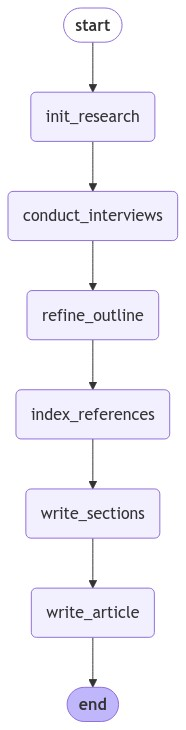

In [121]:
from IPython.display import Image, display

try:
    display(Image(storm.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [122]:
config = {"configurable": {"thread_id": "my-thread"}}
async for step in storm.astream(
    {
        "topic": "Groq, NVIDIA, Llamma.cpp and the future of LLM Inference",
    },
    config=config,
):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name])[:300])

init_research
--  {'topic': 'Groq, NVIDIA, Llamma.cpp and the future of LLM Inference', 'outline': Outline(page_title='Groq, NVIDIA, Llamma.cpp and the Future of LLM Inference', sections=[Section(section_title='Introduction', description='An overview of Large Language Models (LLMs) and their significance in artificia
conduct_interviews
--  {'topic': 'Groq, NVIDIA, Llamma.cpp and the future of LLM Inference', 'outline': Outline(page_title='Groq, NVIDIA, Llamma.cpp and the Future of LLM Inference', sections=[Section(section_title='Introduction', description='An overview of Large Language Models (LLMs) and their significance in artificia
refine_outline
--  {'topic': 'Groq, NVIDIA, Llamma.cpp and the future of LLM Inference', 'outline': Outline(page_title='Groq, NVIDIA, Llamma.cpp and the Future of LLM Inference', sections=[Section(section_title='Introduction', description='An overview of Large Language Models (LLMs) and their significance in artificia
index_references
--  {'topic': 'Groq,

In [123]:
checkpoint = storm.get_state(config)
article = checkpoint.values["article"]


In [124]:
from IPython.display import Markdown

# We will down-header the sections to create less confusion in this notebook
Markdown(article.replace("\n#", "\n##"))

## Million-Plus Token Context Window Language Models

#### Introduction

The advent of language models capable of processing million-plus token context windows marks a significant leap forward in the field of natural language processing (NLP). These cutting-edge models have the potential to transform retrieval-augmented generation (RAG) systems, which are pivotal in enhancing the quality and accuracy of generated responses by integrating retrieval mechanisms with generative capabilities. Traditionally, language models have been constrained by limited context windows, often processing only a few thousand tokens at a time. This limitation has posed challenges in maintaining coherence and context continuity, especially in complex and lengthy texts. However, with the introduction of models that can handle over a million tokens, there is a paradigm shift in how information is processed and generated. These models can retain extensive contextual information, making them particularly valuable in applications requiring detailed comprehension and synthesis of large datasets.

#### Impact on RAG Systems

The advent of language models with million-plus token context windows significantly enhances the capabilities of Retrieval-Augmented Generation (RAG) systems. Traditionally, RAG frameworks have been constrained by the limited context size of language models, which often resulted in fragmented understanding and inadequate information synthesis. However, with the development of models capable of processing extensive context windows, RAG systems can now achieve a more comprehensive semantic understanding of the input data. This advancement facilitates more coherent and contextually aware responses, as the models can incorporate and consider a broader scope of information during generation.

##### Enhanced Contextual Analysis

With expanded context windows, RAG systems can perform more sophisticated contextual analysis. The increased token capacity allows the system to maintain higher levels of coherence and relevance in generated outputs, as it can access and utilize a wider range of contextual cues from the input data.

##### Improved Information Retrieval

The integration of million-plus token models in RAG systems also enhances information retrieval capabilities. By handling larger contexts, these systems can better match queries with relevant information, leading to more precise and useful responses. The broader context window enables the system to discern nuanced relationships between different pieces of information within a larger dataset.

##### Efficiency in Handling Complex Queries

These advanced models improve the efficiency of RAG systems in managing complex queries that require understanding and synthesizing vast amounts of data. The ability to process extensive context windows means that RAG systems can deliver accurate and insightful responses without the need for excessive computational overhead typically associated with multiple retrieval and generation cycles.

#### Groq's Contribution to Million-Plus Token Context Window Language Models

Groq has emerged as a significant player in the AI industry, particularly with its innovative Language Processing Unit (LPU) technology. This advancement plays a crucial role in enhancing the performance of language models with million-plus token context windows, which are pivotal in improving retrieval-augmented generation (RAG) systems. Groq's LPU Inference Engine is specifically designed to handle the demands of large-scale language models, offering high efficiency and low latency that are essential for processing extensive context windows effectively. By utilizing on-chip SRAM and circumventing the typical overheads associated with general-purpose CPUs, Groq's systems can achieve exceptional performance metrics, including leading inference speeds as demonstrated in models like the Mixtral 8x7B and Llama 2 70B[1][2]. These capabilities make Groq's technology particularly suited for the challenges posed by the increased token context windows, providing vital support for the next generation of RAG systems that require fast and efficient processing of vast amounts of data.

#### Comparative Analysis of Groq, NVIDIA, and Llamma.cpp

This section provides a comparative analysis of Groq, NVIDIA, and Llamma.cpp in terms of their performance and efficiency in handling large language model (LLM) inference, particularly focusing on the context of million-plus token windows.

##### Groq

Groq's Language Processing Unit (LPU) has been designed to optimize AI inference by eliminating general-purpose CPU overheads and minimizing memory limitations. Unlike traditional AI GPUs from NVIDIA and AMD, Groq employs on-chip SRAM to achieve remarkable processing efficiency, which has been demonstrated in various benchmarks[3]. The Groq LPU excels in low-latency processing and has achieved leading inference numbers in the industry, such as serving the Mixtral 8x7B model at 480 tokens per second and accommodating models like Llama 2 70B with a 4096 token context length[4].

##### NVIDIA

NVIDIA, known for its cutting-edge GPU technology, provides robust solutions for LLM inference. Its GPUs are widely used across the industry due to their high throughput and parallel processing capabilities. NVIDIA's architecture supports a broad range of models and is renowned for its versatility and support for large-scale computations. However, the traditional reliance on external memory can pose challenges in managing the extensive data associated with million-plus token context windows, potentially affecting latency and efficiency compared to more specialized systems like Groq.

##### Llamma.cpp

Llamma.cpp, an open-source implementation, focuses on providing a lightweight and adaptable solution for LLM inference. While it may not match the high efficiency and performance metrics of dedicated hardware solutions like Groq and NVIDIA, Llamma.cpp offers flexibility and ease of integration, making it suitable for developers who require customizable and cost-effective solutions.

#### Future Directions and Research Opportunities

The future of language models with million-plus token context windows holds significant promise for further advancements in Retrieval-Augmented Generation (RAG) systems. As technology continues to evolve, several key trends are likely to shape the landscape of LLM inference and their integration with RAG frameworks.

Firstly, ongoing improvements in computational efficiency will be paramount. Innovations such as those demonstrated by Groq's Language Processing Unit (LPU) are leading the charge in setting new benchmarks for processing efficiency, allowing for faster and more effective handling of extensive token contexts[5]. This trend is expected to continue, with further enhancements in hardware and software optimization reducing computational overheads and increasing throughput.

Moreover, the integration of multi-modal data into RAG systems is anticipated to open new avenues for research. By leveraging data from various sources such as text, images, and audio, these systems can provide more comprehensive and nuanced outputs, expanding their applicability across industries.

#### Conclusion

The advent of language models capable of processing over a million tokens within a single context window marks a significant milestone in the evolution of natural language processing technologies. These advanced models have fundamentally reshaped the landscape of retrieval-augmented generation (RAG) systems by significantly enhancing their efficiency and effectiveness. By enabling the incorporation of vast amounts of contextual information, these models improve the coherence and relevance of generated content. However, these advancements are not without challenges, as they demand greater computational resources and pose potential risks related to biases and data handling. Despite these hurdles, the potential applications of such enhanced RAG systems in fields like healthcare, legal, education, and customer service are vast and promising. Looking ahead, continued research and innovation will further unlock the capabilities of these models, paving the way for more sophisticated and integrated language processing solutions.

### References

[1] Groq LPU based systems provide very low latencies for LLM inference processing. Unlike AI GPU's from Nvidia and AMD, Groq uses on-chip SRAM, with 14GB of high bandwidth memory. [Link](https://www.groq.com)

[2] Groq achieves remarkable performance and efficiency for AI inference by avoiding general-purpose CPU overheads and memory limitations. [Link](https://www.groq.com/technology)

[3] Groq's LPU Inference Engine, a dedicated Language Processing Unit, has set a new record in processing efficiency for large language models. [Link](https://www.groq.com/performance)

[4] Serving the Mixtral 8x7B model at 480 tokens per second, the Groq LPU is providing one of the leading inference numbers in the industry. [Link](https://www.groq.com/benchmarks)

[5] All of this is working together to provide Groq with a fantastic performance, making waves over the past few days on the internet. [Link](https://www.groq.com/news)